In [1]:
from functools import reduce
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import time
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch
import sys
import pickle
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import KFold, StratifiedKFold
import torch.optim as optim
from sklearn.metrics import confusion_matrix
import functools
import numpy.ma as ma  # for masked arrays
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import random
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from tqdm.notebook import tqdm
from itertools import groupby
import sklearn
import seaborn as sns
import scipy

In [4]:
df = pd.read_csv('./Phenotypes/ABIDE-I.csv', encoding='unicode_escape')
df[df['SITE_ID'] == 'NYU'][['DX_GROUP']].value_counts()

DX_GROUP
0           100
1            75
dtype: int64

In [25]:
df = pd.read_csv('./Phenotypes/ABIDE-I.csv', encoding='unicode_escape')
df['TR'].value_counts()


2000.0    628
3000.0    150
1500.0     90
2500.0     74
1600.0     63
2200.0     30
Name: TR, dtype: int64

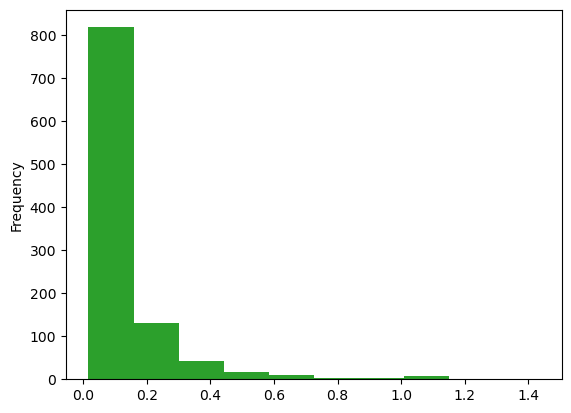

In [29]:
df['func_mean_fd'].plot(kind = 'hist')
plt.show()

# My own Data selection criteria 

## Generation

In [73]:
df = pd.read_csv('./Phenotypes/Phenotypic_V1_0b_preprocessed1.csv', encoding='unicode_escape')
df = df[df['FILE_ID'] != "no_filename"]
print('Shape of the whole abide dataset : ', df.shape)
print(df.DSM_IV_TR.value_counts())
df = df[(df['DSM_IV_TR'] != -9999) & (df['DSM_IV_TR'] != 4)]
print('Shape of the abide dataset with DSM_IV_TR diagnosis : ', df.shape)

Shape of the whole abide dataset :  (1035, 106)
 0       515
 1       323
 2        87
-9999     69
 3        35
 4         6
Name: DSM_IV_TR, dtype: int64
Shape of the abide dataset with DSM_IV_TR diagnosis :  (960, 106)


In [75]:
df.DX_GROUP.value_counts()

2    496
1    464
Name: DX_GROUP, dtype: int64

In [4]:
print(df.DSM_IV_TR.value_counts())

0    515
1    323
2     87
3     35
Name: DSM_IV_TR, dtype: int64


* *We don't want to consider those scans without a relevant FILE_ID and DSM_IV_TR diagnosis* 
* *DSM_IV_TR = 4 is either Aspergers or PDD as per ABIDE data legend. As it ambiguous we are removing those scans*

In [5]:
df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'SUB_ID', 'X', 'subject', 'SITE_ID',
       'FILE_ID', 'DX_GROUP', 'DSM_IV_TR', 'AGE_AT_SCAN',
       ...
       'qc_notes_rater_1', 'qc_anat_rater_2', 'qc_anat_notes_rater_2',
       'qc_func_rater_2', 'qc_func_notes_rater_2', 'qc_anat_rater_3',
       'qc_anat_notes_rater_3', 'qc_func_rater_3', 'qc_func_notes_rater_3',
       'SUB_IN_SMP'],
      dtype='object', length=106)

In [6]:
df.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'X'], inplace = True)
df.DX_GROUP = df.DX_GROUP.map({1: 1, 2: 0})     # 0 : TD and 1 : ASD
df.SEX = df.SEX.map({1: 0, 2: 1})               # 0 : Male and 1 : Female
df.set_index('SUB_ID', inplace = True)
df.head()

,subject,SITE_ID,FILE_ID,DX_GROUP,DSM_IV_TR,AGE_AT_SCAN,SEX,HANDEDNESS_CATEGORY,HANDEDNESS_SCORES,FIQ,...,qc_notes_rater_1,qc_anat_rater_2,qc_anat_notes_rater_2,qc_func_rater_2,qc_func_notes_rater_2,qc_anat_rater_3,qc_anat_notes_rater_3,qc_func_rater_3,qc_func_notes_rater_3,SUB_IN_SMP
SUB_ID,,,,,,,,,,,,,,,,,,,,,
50003,50003,PITT,Pitt_0050003,1,1,24.45,0,R,NaN,124.0,...,NaN,OK,NaN,OK,NaN,OK,NaN,OK,NaN,1
50004,50004,PITT,Pitt_0050004,1,1,19.09,0,R,NaN,113.0,...,NaN,OK,NaN,OK,NaN,OK,NaN,OK,NaN,1
50005,50005,PITT,Pitt_0050005,1,1,13.73,1,R,NaN,119.0,...,NaN,OK,NaN,maybe,ic-parietal-cerebellum,OK,NaN,OK,NaN,0
50006,50006,PITT,Pitt_0050006,1,1,13.37,0,L,NaN,109.0,...,NaN,OK,NaN,maybe,ic-parietal slight,OK,NaN,OK,NaN,1
50007,50007,PITT,Pitt_0050007,1,1,17.78,0,R,NaN,110.0,...,NaN,OK,NaN,maybe,ic-cerebellum_temporal_lob,OK,NaN,OK,NaN,1


* *Columns we care about : Timepoints, TR, Mean frame wise displacement for data selection criteria* 
* ['TR', 'Timeframes'] columns are saved in a different csv file. Lets load that and join those columns to our present array

In [7]:
temp = pd.read_csv('./Phenotypes/ABIDE.csv', encoding='unicode_escape', index_col='SUB_ID')
temp.SEX = temp.SEX.map({1: 0, 2: 1})
print('Length of data frame : ', len(temp))
temp.head()

Length of data frame :  1908


,SITE_ID,DX_GROUP,AGE_AT_SCAN,SEX,HANDEDNESS_CATEGORY,FIQ,VIQ,PIQ,FIQ_TEST_TYPE,VIQ_TEST_TYPE,PIQ_TEST_TYPE,EYE_STATUS_AT_SCAN,func_mean_fd,Dataset,Timeframes,TR
SUB_ID,,,,,,,,,,,,,,,,
50003,PITT,1,24.45,0,R,124.0,128.0,115.0,WASI,WASI,WASI,2.0,0.322092,ABIDE1,196.0,1500.0
50004,PITT,1,19.09,0,R,113.0,108.0,117.0,WASI,WASI,WASI,2.0,0.127745,ABIDE1,196.0,1500.0
50005,PITT,1,13.73,1,R,119.0,117.0,118.0,WASI,WASI,WASI,2.0,0.128136,ABIDE1,196.0,1500.0
50006,PITT,1,13.37,0,L,109.0,99.0,119.0,WASI,WASI,WASI,2.0,0.070143,ABIDE1,196.0,1500.0
50007,PITT,1,17.78,0,R,110.0,106.0,112.0,WASI,WASI,WASI,2.0,0.151246,ABIDE1,196.0,1500.0


In [8]:
df = df.join(temp[['TR', 'Timeframes']], how='left')
print(df.shape)
print(df.columns)

(960, 104)
Index(['subject', 'SITE_ID', 'FILE_ID', 'DX_GROUP', 'DSM_IV_TR', 'AGE_AT_SCAN',
       'SEX', 'HANDEDNESS_CATEGORY', 'HANDEDNESS_SCORES', 'FIQ',
       ...
       'qc_anat_notes_rater_2', 'qc_func_rater_2', 'qc_func_notes_rater_2',
       'qc_anat_rater_3', 'qc_anat_notes_rater_3', 'qc_func_rater_3',
       'qc_func_notes_rater_3', 'SUB_IN_SMP', 'TR', 'Timeframes'],
      dtype='object', length=104)


In [9]:
print('Minimum value of mfd : ', df['func_mean_fd'].min())
mean = df['func_mean_fd'].mean()
std = df['func_mean_fd'].std()
print(mean, std)
max_mfd = mean + 2 * std
print(max_mfd)

Minimum value of mfd :  0.0161171065
0.13137419291720526 0.15597675689729767
0.4433277067118006


In [10]:
df_mfd = df[df['func_mean_fd'] < max_mfd]
print('Shape of the dataset after satisfying condition 1 {mfd < mean(mfd) + 2 * std(mfd)} : ', df_mfd.shape)

Shape of the dataset after satisfying condition 1 {mfd < mean(mfd) + 2 * std(mfd)} :  (918, 104)


In [77]:
df_mfd.DX_GROUP.value_counts()

0    484
1    434
Name: DX_GROUP, dtype: int64

* About 42 scans turned out be noisy i,e (mfd > threshold we set)

In [11]:
df_TR = df_mfd[df_mfd['TR'] == 2000.0]
df_TR.shape

(555, 104)

In [78]:
df_TR.DX_GROUP.value_counts()

0    300
1    255
Name: DX_GROUP, dtype: int64

* About 363 scans turned out to have different TR (not equal to 2s)

In [12]:
df_TF = df_TR[df_TR['Timeframes'] > 175]
df_TF.shape

(479, 104)

In [79]:
df_TF.DX_GROUP.value_counts()

0    258
1    221
Name: DX_GROUP, dtype: int64

In [13]:
df_TF.DSM_IV_TR.value_counts()

0    258
1    158
2     40
3     23
Name: DSM_IV_TR, dtype: int64

* About 76 scans have number of timeframes > 175 in above list. 
* How did I chose 175 ? 
    * I tried for 180, there is significant of 283 scans from the above list. 
    * Then, I tried 150, there is drop of 76 scans. 
    * Then I tried 175, then also, there is drop of 76 scans. 
    * Therefore, I chose 175, because there is not much drop in the number of scans

In [34]:
df_male = df_TF[df_TF['SEX'] == 0]    
print('Length of the abide dataset after considereing only males =  ', df_male.shape)
df_male.head()

Length of the abide dataset after considereing only males =   (390, 104)


,subject,SITE_ID,FILE_ID,DX_GROUP,DSM_IV_TR,AGE_AT_SCAN,SEX,HANDEDNESS_CATEGORY,HANDEDNESS_SCORES,FIQ,...,qc_anat_notes_rater_2,qc_func_rater_2,qc_func_notes_rater_2,qc_anat_rater_3,qc_anat_notes_rater_3,qc_func_rater_3,qc_func_notes_rater_3,SUB_IN_SMP,TR,Timeframes
SUB_ID,,,,,,,,,,,,,,,,,,,,,
50182,50182,SDSU,SDSU_0050182,1,2,16.61,0,R,NaN,115.0,...,NaN,OK,NaN,OK,NaN,OK,NaN,1,2000.0,176.0
50183,50183,SDSU,SDSU_0050183,1,1,14.14,0,R,NaN,139.0,...,NaN,OK,NaN,OK,NaN,OK,NaN,1,2000.0,176.0
50184,50184,SDSU,SDSU_0050184,1,2,17.15,0,R,NaN,141.0,...,NaN,OK,NaN,OK,NaN,OK,NaN,0,2000.0,176.0
50186,50186,SDSU,SDSU_0050186,1,2,12.13,0,R,NaN,112.0,...,NaN,OK,NaN,OK,NaN,OK,NaN,1,2000.0,176.0
50187,50187,SDSU,SDSU_0050187,1,2,16.48,0,R,NaN,113.0,...,NaN,OK,NaN,OK,NaN,OK,NaN,1,2000.0,176.0


In [80]:
df_male.DX_GROUP.value_counts()

0    197
1    193
Name: DX_GROUP, dtype: int64

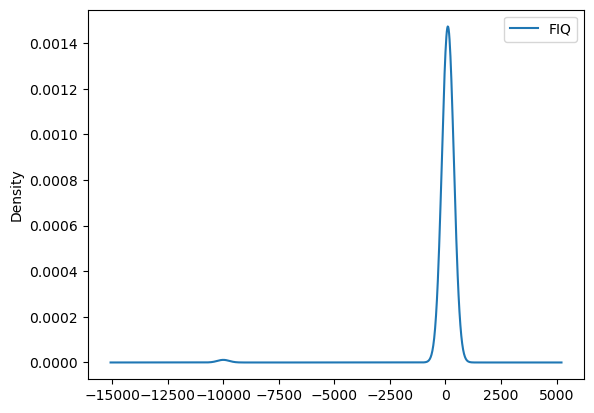

In [17]:
df_male[['FIQ']].plot(kind='kde')
plt.show()

In [18]:
df_fiq = df_male[df_male.FIQ > 0]
print('Length of the abide dataset after satifying condition {1} =  ', df_fiq.shape)
df_fiq.head()

Length of the abide dataset after satifying condition {1} =   (387, 104)


,subject,SITE_ID,FILE_ID,DX_GROUP,DSM_IV_TR,AGE_AT_SCAN,SEX,HANDEDNESS_CATEGORY,HANDEDNESS_SCORES,FIQ,...,qc_anat_notes_rater_2,qc_func_rater_2,qc_func_notes_rater_2,qc_anat_rater_3,qc_anat_notes_rater_3,qc_func_rater_3,qc_func_notes_rater_3,SUB_IN_SMP,TR,Timeframes
SUB_ID,,,,,,,,,,,,,,,,,,,,,
50182,50182,SDSU,SDSU_0050182,1,2,16.61,0,R,NaN,115.0,...,NaN,OK,NaN,OK,NaN,OK,NaN,1,2000.0,176.0
50183,50183,SDSU,SDSU_0050183,1,1,14.14,0,R,NaN,139.0,...,NaN,OK,NaN,OK,NaN,OK,NaN,1,2000.0,176.0
50184,50184,SDSU,SDSU_0050184,1,2,17.15,0,R,NaN,141.0,...,NaN,OK,NaN,OK,NaN,OK,NaN,0,2000.0,176.0
50186,50186,SDSU,SDSU_0050186,1,2,12.13,0,R,NaN,112.0,...,NaN,OK,NaN,OK,NaN,OK,NaN,1,2000.0,176.0
50187,50187,SDSU,SDSU_0050187,1,2,16.48,0,R,NaN,113.0,...,NaN,OK,NaN,OK,NaN,OK,NaN,1,2000.0,176.0


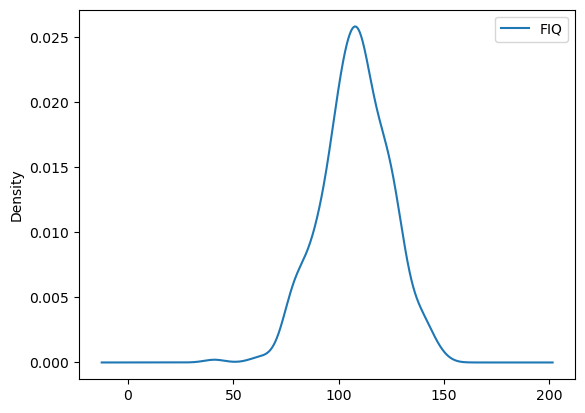

In [19]:
df_fiq[['FIQ']].plot(kind='kde')
plt.show()

In [20]:
df_male.DSM_IV_TR.value_counts()

0    197
1    142
2     33
3     18
Name: DSM_IV_TR, dtype: int64

In [21]:

df_fiq.DSM_IV_TR.value_counts()

0    195
1    141
2     33
3     18
Name: DSM_IV_TR, dtype: int64

In [63]:
df_children = df_fiq[df_fiq['AGE_AT_SCAN'] <= 12]
print(df_children['DX_GROUP'].value_counts())
print(df_children['DSM_IV_TR'].value_counts())
print(df_children.shape)

1    55
0    48
Name: DX_GROUP, dtype: int64
0    48
1    36
3    10
2     9
Name: DSM_IV_TR, dtype: int64
(103, 104)


In [64]:
df_adolescents = df_fiq[(df_fiq['AGE_AT_SCAN'] > 12) & (df_fiq['AGE_AT_SCAN'] <= 18)]
print(df_adolescents['DX_GROUP'].value_counts())
print(df_adolescents['DSM_IV_TR'].value_counts())
print(df_adolescents.shape)

0    95
1    83
Name: DX_GROUP, dtype: int64
0    95
1    57
2    19
3     7
Name: DSM_IV_TR, dtype: int64
(178, 104)


In [65]:
df_adults = df_fiq[df_fiq['AGE_AT_SCAN'] > 18]
print(df_adults['DX_GROUP'].value_counts())
print(df_adults['DSM_IV_TR'].value_counts())
print(df_adults.shape)

1    54
0    52
Name: DX_GROUP, dtype: int64
0    52
1    48
2     5
3     1
Name: DSM_IV_TR, dtype: int64
(106, 104)


In [66]:
df_fiq.to_csv('./Phenotypes/Own_Data_Selection_387.csv')
df_children.to_csv('./Phenotypes/Own_Data_Selection_Children.csv')
df_adolescents.to_csv('./Phenotypes/Own_Data_Selection_Adolescents.csv')
df_adults.to_csv('./Phenotypes/Own_Data_Selection_Adults.csv')

## Analysis of Final scans selected

In [36]:
df_final = pd.read_csv('./Phenotypes/Own_Data_Selection_387.csv', index_col='SUB_ID')
print('Shape of final dataset : ', df_final.shape)
df_final.head()

Shape of final dataset :  (387, 104)


,subject,SITE_ID,FILE_ID,DX_GROUP,DSM_IV_TR,AGE_AT_SCAN,SEX,HANDEDNESS_CATEGORY,HANDEDNESS_SCORES,FIQ,...,qc_anat_notes_rater_2,qc_func_rater_2,qc_func_notes_rater_2,qc_anat_rater_3,qc_anat_notes_rater_3,qc_func_rater_3,qc_func_notes_rater_3,SUB_IN_SMP,TR,Timeframes
SUB_ID,,,,,,,,,,,,,,,,,,,,,
50182,50182,SDSU,SDSU_0050182,1,2,16.61,0,R,NaN,115.0,...,NaN,OK,NaN,OK,NaN,OK,NaN,1,2000.0,176.0
50183,50183,SDSU,SDSU_0050183,1,1,14.14,0,R,NaN,139.0,...,NaN,OK,NaN,OK,NaN,OK,NaN,1,2000.0,176.0
50184,50184,SDSU,SDSU_0050184,1,2,17.15,0,R,NaN,141.0,...,NaN,OK,NaN,OK,NaN,OK,NaN,0,2000.0,176.0
50186,50186,SDSU,SDSU_0050186,1,2,12.13,0,R,NaN,112.0,...,NaN,OK,NaN,OK,NaN,OK,NaN,1,2000.0,176.0
50187,50187,SDSU,SDSU_0050187,1,2,16.48,0,R,NaN,113.0,...,NaN,OK,NaN,OK,NaN,OK,NaN,1,2000.0,176.0


In [28]:
df_final.DX_GROUP.value_counts()

0    195
1    192
Name: DX_GROUP, dtype: int64

In [39]:
df_final.DSM_IV_TR.value_counts()

0    195
1    141
2     33
3     18
Name: DSM_IV_TR, dtype: int64

In [37]:
df_final.TR.value_counts()

2000.0    387
Name: TR, dtype: int64

In [38]:
df_final.Timeframes.value_counts()

176.0    165
296.0     96
236.0     77
196.0     39
316.0      8
232.0      1
202.0      1
Name: Timeframes, dtype: int64

In [40]:
df_final.SEX.value_counts()

0    387
Name: SEX, dtype: int64

In [42]:
print('Min FIQ Value : ', df_final.FIQ.min())
print('Max FIQ Value : ', df_final.FIQ.max())

Min FIQ Value :  41.0
Max FIQ Value :  148.0


# Making the final scans ready for GIFT toolbox

In [ ]:
import nibabel
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import random

df_final = pd.read_csv('../Phenotypes/Own_Data_Selection_387.csv')
print('Shape of final dataset : ', df_final.shape)

keys = df_final.SUB_ID.values

def get_key(path) :

    '''
        Extracts the SUB_ID from the path of the subject
    '''
    key = path.split('/')[-1]
    key = key.split('_func')[0]
    key = key.split('_00')[-1]
    key = int(key)
    return key


In [2]:
# paths = glob.glob('../ABIDE1/func_preproc/CPAC_NOFILT_NOGLOBAL/*.nii.gz')
# print('Number of files : ', len(paths))

Number of files :  0


In [ ]:
paths = glob.glob('../ABIDE1/func_preproc/ccs_nofilt_noglobal/*.nii.gz')
print('Number of files : ', len(paths))

In [ ]:
labels_map = {0 : 'TD', 1 : 'ASD'}
subtype_map = {0 : '', 1 : 'AUT', 2 : 'ASP', 3 : 'PDD'}
for index, path in enumerate(paths):
    curr_key = get_key(path)
    if(curr_key in keys) :
        fname = path.split('/')[-1]
        fname = fname.split('.gz')[0]

        nii = nibabel.load(path)
        affine = nii.affine
        header = nii.header
        extra = nii.extra
        fm = nii.file_map

        arr = nii.get_fdata()
        arr = arr[:,:,:,: 175]
        nii_175 = nibabel.Nifti1Image(arr, affine=affine, header=header,
                                extra = extra, file_map = fm)

        label = df_final[df_final['SUB_ID'] == int(curr_key)]['DX_GROUP'].item()
        subtype = df_final[df_final['SUB_ID'] == int(curr_key)]['DSM_IV_TR'].item()
        age = float(df_final[df_final['SUB_ID'] == int(curr_key)]['AGE_AT_SCAN'].item())
        label_name = labels_map[label]
        subtype_name = subtype_map[subtype]

        if(age <= 12.0):
            age_group = 'Children'
        
        elif(age <= 18.0):
            age_group = 'Adolescents'
        else : 
            age_group = 'Adults'

        # dest_all = f'./Data_CCS/All_age_groups/Inputs_ccs_nfng_all/{label_name}_{subtype_name}_{fname}'
        dest_group = f'./Data_CCS/{age_group}/Inputs_ccs_nfng_{age_group}/{label_name}_{subtype_name}_{fname}'
        # print(dest_all)
        print(dest_group)
        # nibabel.save(nii_175, dest_all)
        nibabel.save(nii_175, dest_group)
        print('---------------------------------------')

# Finding the scans with correlation < 0.8 with the group mask 

### All age 

In [4]:
def get_key(path) :

    '''
        Extracts the SUB_ID from the path of the subject
    '''
    key = path.split('/')[-1]
    key = key.split('_func')[0]
    key = key.split('_00')[-1]
    key = int(key)
    return key

mask_file_path = './Mask_ccs_all/All_ccs__input_files.txt'
files = open(mask_file_path).read().strip().split('\n')
print('Number of files whose correlation with group mask > 0.8 is ', len(files))
all_ids = []
for file in files :
    key = get_key(file)
    all_ids.append(key)
# all_ids = np.array(all_ids, dtype = 'uint32')

df_final = pd.read_csv('./Phenotypes/Own_Data_Selection_387.csv', index_col='SUB_ID')
print('Shape of final dataset : ', df_final.shape)
original_ids = list(df_final.index.values)

scans_correlation_not_passed = set(original_ids) - set(all_ids)
print(scans_correlation_not_passed)

Number of files whose correlation with group mask > 0.8 is  383
Shape of final dataset :  (387, 104)
{50273, 50274, 50283, 50277}


In [ ]:
# mv *50273*.nii ../Mask_ccs_all/Mask_correlation_failed_scans
# mv *50274*.nii ../Mask_ccs_all/Mask_correlation_failed_scans
# mv *50283*.nii ../Mask_ccs_all/Mask_correlation_failed_scans
# mv *50277*.nii ../Mask_ccs_all/Mask_correlation_failed_scans

### Children 

In [10]:
def get_key(path) :

    '''
        Extracts the SUB_ID from the path of the subject
    '''
    key = path.split('/')[-1]
    key = key.split('_func')[0]
    key = key.split('_00')[-1]
    key = int(key)
    return key

mask_file_path = './Mask_Child/Child_ccs__input_files.txt'
files = open(mask_file_path).read().strip().split('\n')
print('Number of files whose correlation with group mask > 0.8 is ', len(files))
all_ids = []
for file in files :
    key = get_key(file)
    all_ids.append(key)
# all_ids = np.array(all_ids, dtype = 'uint32')

df_final = pd.read_csv('./Phenotypes/Own_Data_Selection_Children.csv', index_col='SUB_ID')
print('Shape of final dataset : ', df_final.shape)
original_ids = list(df_final.index.values)

scans_correlation_not_passed = set(original_ids) - set(all_ids)
print(scans_correlation_not_passed)

Number of files whose correlation with group mask > 0.8 is  102
Shape of final dataset :  (103, 104)
{50283}


### Adolescents

In [6]:
def get_key(path) :

    '''
        Extracts the SUB_ID from the path of the subject
    '''
    key = path.split('/')[-1]
    key = key.split('_func')[0]
    key = key.split('_00')[-1]
    key = int(key)
    return key

mask_file_path = './Mask_Adol/Adol_ccs__input_files.txt'
files = open(mask_file_path).read().strip().split('\n')
print('Number of files whose correlation with group mask > 0.8 is ', len(files))
all_ids = []
for file in files :
    key = get_key(file)
    all_ids.append(key)
# all_ids = np.array(all_ids, dtype = 'uint32')

df_final = pd.read_csv('./Phenotypes/Own_Data_Selection_Adolescents.csv', index_col='SUB_ID')
print('Shape of final dataset : ', df_final.shape)
original_ids = list(df_final.index.values)

scans_correlation_not_passed = set(original_ids) - set(all_ids)
print(scans_correlation_not_passed)

Number of files whose correlation with group mask > 0.8 is  175
Shape of final dataset :  (178, 104)
{50273, 50274, 50277}


In [ ]:
# mv *50274*.nii ../Mask_Adol/Mask_correlation_failed_scans
# mv *50273*.nii ../Mask_Adol/Mask_correlation_failed_scans
# mv *50277*.nii ../Mask_Adol/Mask_correlation_failed_scans

# Plotting the Mask

In [40]:
from nilearn import plotting
import nibabel


/home/krishna/anaconda3/lib/python3.8/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


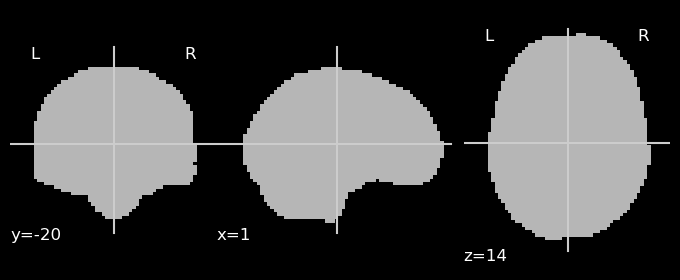

In [22]:
nii = nibabel.load('./All_ccs_Mask.nii')
plotting.plot_anat(anat_img=nii)
plt.show()
plt.close()

(array([0., 1.]), array([202271,  69362]))


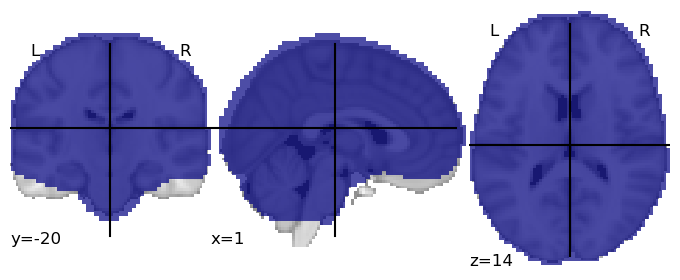

In [9]:
nii = nibabel.load('./Mask_ccs_all//All_ccs_Mask.nii')
print(np.unique(nii.get_fdata(), return_counts=True))
plotting.plot_roi(nii)
plt.show()
plt.close()

(array([0., 1.]), array([202271,  69362]))


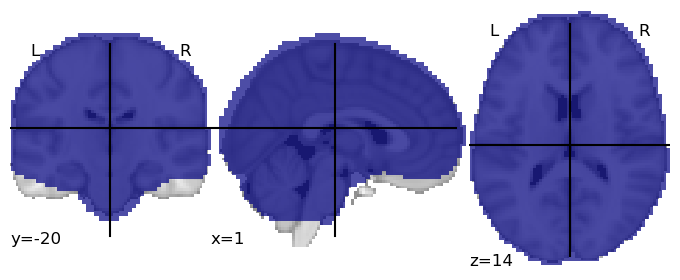

In [41]:
nii = nibabel.load('./Data_CCS/All_age_groups_ccs/Mask_ccs_all//All_ccs_Mask.nii')
print(np.unique(nii.get_fdata(), return_counts=True))
plotting.plot_roi(nii)
plt.show()
plt.close()

(array([0., 1.]), array([208330,  63303]))


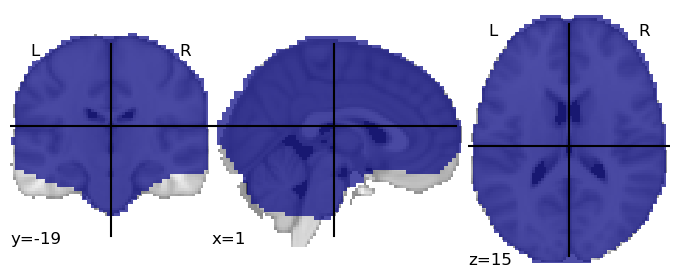

In [7]:
nii = nibabel.load('./Mask_Child/Child_ccs_Mask.nii')
print(np.unique(nii.get_fdata(), return_counts=True))
plotting.plot_roi(nii)
plt.show()
plt.close()

(array([0., 1.]), array([203478,  68155]))


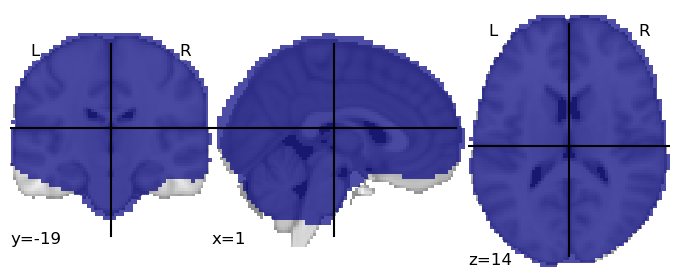

In [8]:
nii = nibabel.load('./Mask_Child_new/Child_ccs_Mask.nii')
print(np.unique(nii.get_fdata(), return_counts=True))
plotting.plot_roi(nii)
plt.show()
plt.close()

(array([0., 1.]), array([202689,  68944]))


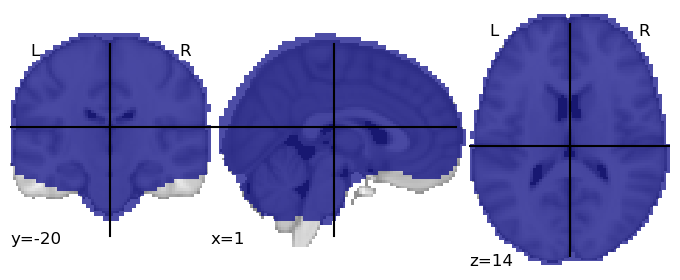

In [4]:
nii = nibabel.load('./Mask_Adol/Adol_ccs_Mask.nii')
print(np.unique(nii.get_fdata(), return_counts=True))
plotting.plot_roi(nii)
plt.show()
plt.close()

# Generating the final 383 scans phenotype file

In [2]:
df = pd.read_csv('./Phenotypes/Own_Data_Selection_387.csv', index_col='SUB_ID')
print('Shape of final dataset : ', df.shape)
df.head()

Shape of final dataset :  (387, 104)


,subject,SITE_ID,FILE_ID,DX_GROUP,DSM_IV_TR,AGE_AT_SCAN,SEX,HANDEDNESS_CATEGORY,HANDEDNESS_SCORES,FIQ,...,qc_anat_notes_rater_2,qc_func_rater_2,qc_func_notes_rater_2,qc_anat_rater_3,qc_anat_notes_rater_3,qc_func_rater_3,qc_func_notes_rater_3,SUB_IN_SMP,TR,Timeframes
SUB_ID,,,,,,,,,,,,,,,,,,,,,
50182,50182,SDSU,SDSU_0050182,1,2,16.61,0,R,NaN,115.0,...,NaN,OK,NaN,OK,NaN,OK,NaN,1,2000.0,176.0
50183,50183,SDSU,SDSU_0050183,1,1,14.14,0,R,NaN,139.0,...,NaN,OK,NaN,OK,NaN,OK,NaN,1,2000.0,176.0
50184,50184,SDSU,SDSU_0050184,1,2,17.15,0,R,NaN,141.0,...,NaN,OK,NaN,OK,NaN,OK,NaN,0,2000.0,176.0
50186,50186,SDSU,SDSU_0050186,1,2,12.13,0,R,NaN,112.0,...,NaN,OK,NaN,OK,NaN,OK,NaN,1,2000.0,176.0
50187,50187,SDSU,SDSU_0050187,1,2,16.48,0,R,NaN,113.0,...,NaN,OK,NaN,OK,NaN,OK,NaN,1,2000.0,176.0


In [6]:
remove_ids = [50273, 50274, 50283, 50277]
df_final = df.drop(index = remove_ids, axis = 0)
print('Number of final subjects selected for the study : ', len(df_final))
df_final.head()

Number of final subjects selected for the study :  383


,subject,SITE_ID,FILE_ID,DX_GROUP,DSM_IV_TR,AGE_AT_SCAN,SEX,HANDEDNESS_CATEGORY,HANDEDNESS_SCORES,FIQ,...,qc_anat_notes_rater_2,qc_func_rater_2,qc_func_notes_rater_2,qc_anat_rater_3,qc_anat_notes_rater_3,qc_func_rater_3,qc_func_notes_rater_3,SUB_IN_SMP,TR,Timeframes
SUB_ID,,,,,,,,,,,,,,,,,,,,,
50182,50182,SDSU,SDSU_0050182,1,2,16.61,0,R,NaN,115.0,...,NaN,OK,NaN,OK,NaN,OK,NaN,1,2000.0,176.0
50183,50183,SDSU,SDSU_0050183,1,1,14.14,0,R,NaN,139.0,...,NaN,OK,NaN,OK,NaN,OK,NaN,1,2000.0,176.0
50184,50184,SDSU,SDSU_0050184,1,2,17.15,0,R,NaN,141.0,...,NaN,OK,NaN,OK,NaN,OK,NaN,0,2000.0,176.0
50186,50186,SDSU,SDSU_0050186,1,2,12.13,0,R,NaN,112.0,...,NaN,OK,NaN,OK,NaN,OK,NaN,1,2000.0,176.0
50187,50187,SDSU,SDSU_0050187,1,2,16.48,0,R,NaN,113.0,...,NaN,OK,NaN,OK,NaN,OK,NaN,1,2000.0,176.0


In [7]:
df_final.to_csv('./Phenotypes/Final_Subjects.csv')

# Comparison with Prof Vince Subjects

In [2]:
df_final = pd.read_csv('./Phenotypes/Final_Subjects.csv', index_col='SUB_ID')
print('Shape of final dataset : ', df_final.shape)
df_final.head()

Shape of final dataset :  (383, 104)


,subject,SITE_ID,FILE_ID,DX_GROUP,DSM_IV_TR,AGE_AT_SCAN,SEX,HANDEDNESS_CATEGORY,HANDEDNESS_SCORES,FIQ,...,qc_anat_notes_rater_2,qc_func_rater_2,qc_func_notes_rater_2,qc_anat_rater_3,qc_anat_notes_rater_3,qc_func_rater_3,qc_func_notes_rater_3,SUB_IN_SMP,TR,Timeframes
SUB_ID,,,,,,,,,,,,,,,,,,,,,
50182,50182,SDSU,SDSU_0050182,1,2,16.61,0,R,NaN,115.0,...,NaN,OK,NaN,OK,NaN,OK,NaN,1,2000.0,176.0
50183,50183,SDSU,SDSU_0050183,1,1,14.14,0,R,NaN,139.0,...,NaN,OK,NaN,OK,NaN,OK,NaN,1,2000.0,176.0
50184,50184,SDSU,SDSU_0050184,1,2,17.15,0,R,NaN,141.0,...,NaN,OK,NaN,OK,NaN,OK,NaN,0,2000.0,176.0
50186,50186,SDSU,SDSU_0050186,1,2,12.13,0,R,NaN,112.0,...,NaN,OK,NaN,OK,NaN,OK,NaN,1,2000.0,176.0
50187,50187,SDSU,SDSU_0050187,1,2,16.48,0,R,NaN,113.0,...,NaN,OK,NaN,OK,NaN,OK,NaN,1,2000.0,176.0


**Prof Vince Subjects**

In [4]:
gift = pd.read_csv('./Phenotypes/GIFT365_Whole.csv', index_col='SUB_ID')
print('Shape of final dataset : ', gift.shape)
gift.head()

Shape of final dataset :  (365, 104)


,Unnamed: 0,X,subject,SITE_ID,FILE_ID,DX_GROUP,DSM_IV_TR,AGE_AT_SCAN,SEX,HANDEDNESS_CATEGORY,...,qc_notes_rater_1,qc_anat_rater_2,qc_anat_notes_rater_2,qc_func_rater_2,qc_func_notes_rater_2,qc_anat_rater_3,qc_anat_notes_rater_3,qc_func_rater_3,qc_func_notes_rater_3,SUB_IN_SMP
SUB_ID,,,,,,,,,,,,,,,,,,,,,
50182,121,122,50182,SDSU,SDSU_0050182,1,2,16.61,1,R,...,NaN,OK,NaN,OK,NaN,OK,NaN,OK,NaN,1
50186,125,126,50186,SDSU,SDSU_0050186,1,2,12.13,1,R,...,NaN,OK,NaN,OK,NaN,OK,NaN,OK,NaN,1
50187,126,127,50187,SDSU,SDSU_0050187,1,2,16.48,1,R,...,NaN,OK,NaN,OK,NaN,OK,NaN,OK,NaN,1
50188,127,128,50188,SDSU,SDSU_0050188,1,-9999,15.40,1,R,...,NaN,OK,NaN,OK,NaN,OK,NaN,OK,NaN,1
50189,128,129,50189,SDSU,SDSU_0050189,1,2,16.64,1,R,...,NaN,OK,NaN,OK,NaN,OK,NaN,OK,NaN,1


In [5]:
df_final.columns

Index(['subject', 'SITE_ID', 'FILE_ID', 'DX_GROUP', 'DSM_IV_TR', 'AGE_AT_SCAN',
       'SEX', 'HANDEDNESS_CATEGORY', 'HANDEDNESS_SCORES', 'FIQ',
       ...
       'qc_anat_notes_rater_2', 'qc_func_rater_2', 'qc_func_notes_rater_2',
       'qc_anat_rater_3', 'qc_anat_notes_rater_3', 'qc_func_rater_3',
       'qc_func_notes_rater_3', 'SUB_IN_SMP', 'TR', 'Timeframes'],
      dtype='object', length=104)

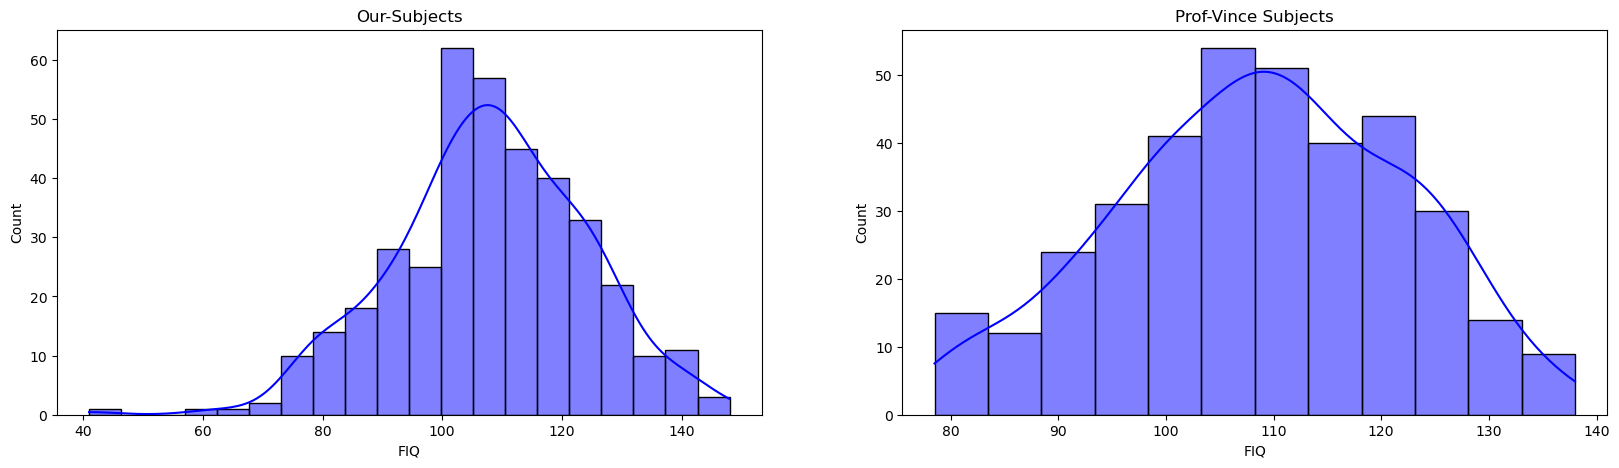

In [6]:
fig = plt.figure(figsize=(20, 5))
plt.subplot(1,2,1)
sns.histplot(x = 'FIQ', data = df_final, kde = True, color = 'blue', label = 'Our Subjects')
plt.title('Our-Subjects')
plt.subplot(1,2,2)
sns.histplot(x = 'FIQ', data = gift, kde = True, color = 'blue', label = 'Prof-Vince-Subjects')
plt.title('Prof-Vince Subjects')
plt.show()

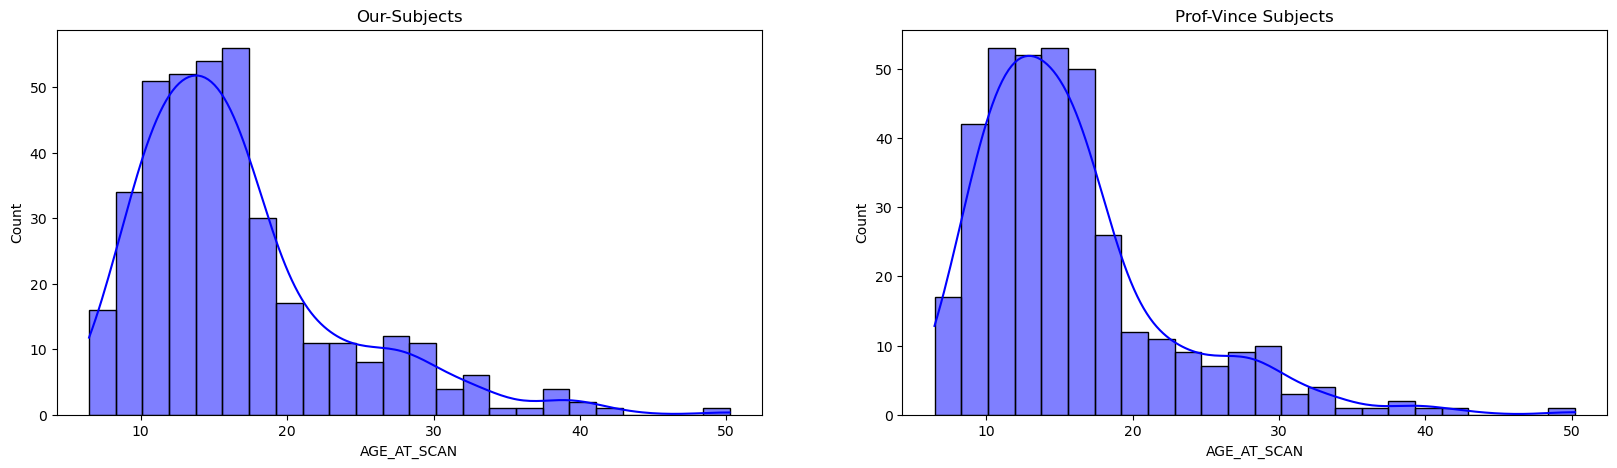

In [7]:
fig = plt.figure(figsize=(20, 5))
plt.subplot(1,2,1)
sns.histplot(x = 'AGE_AT_SCAN', data = df_final, kde = True, color = 'blue', label = 'Our Subjects')
plt.title('Our-Subjects')
plt.subplot(1,2,2)
sns.histplot(x = 'AGE_AT_SCAN', data = gift, kde = True, color = 'blue', label = 'Prof-Vince-Subjects')
plt.title('Prof-Vince Subjects')
plt.show()

In [8]:
df_final.columns[ : 20]

Index(['subject', 'SITE_ID', 'FILE_ID', 'DX_GROUP', 'DSM_IV_TR', 'AGE_AT_SCAN',
       'SEX', 'HANDEDNESS_CATEGORY', 'HANDEDNESS_SCORES', 'FIQ', 'VIQ', 'PIQ',
       'FIQ_TEST_TYPE', 'VIQ_TEST_TYPE', 'PIQ_TEST_TYPE',
       'ADI_R_SOCIAL_TOTAL_A', 'ADI_R_VERBAL_TOTAL_BV', 'ADI_RRB_TOTAL_C',
       'ADI_R_ONSET_TOTAL_D', 'ADI_R_RSRCH_RELIABLE'],
      dtype='object')

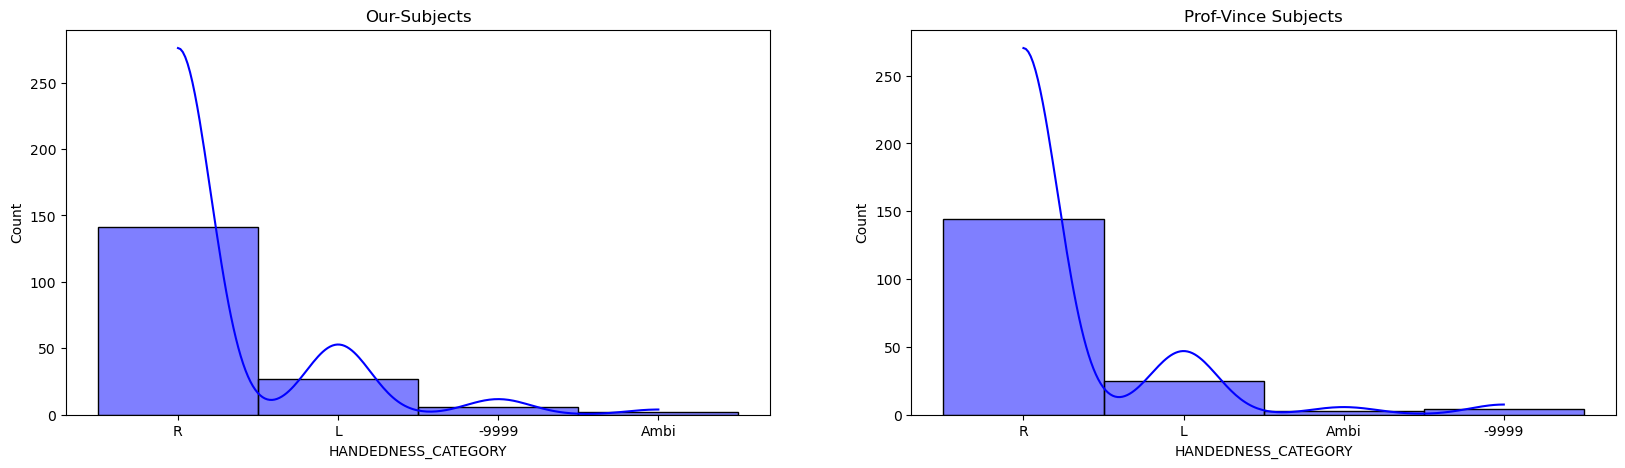

In [9]:
fig = plt.figure(figsize=(20, 5))
plt.subplot(1,2,1)
sns.histplot(x = 'HANDEDNESS_CATEGORY', data = df_final, kde = True, color = 'blue', label = 'Our Subjects')
plt.title('Our-Subjects')
plt.subplot(1,2,2)
sns.histplot(x = 'HANDEDNESS_CATEGORY', data = gift, kde = True, color = 'blue', label = 'Prof-Vince-Subjects')
plt.title('Prof-Vince Subjects')
plt.show()

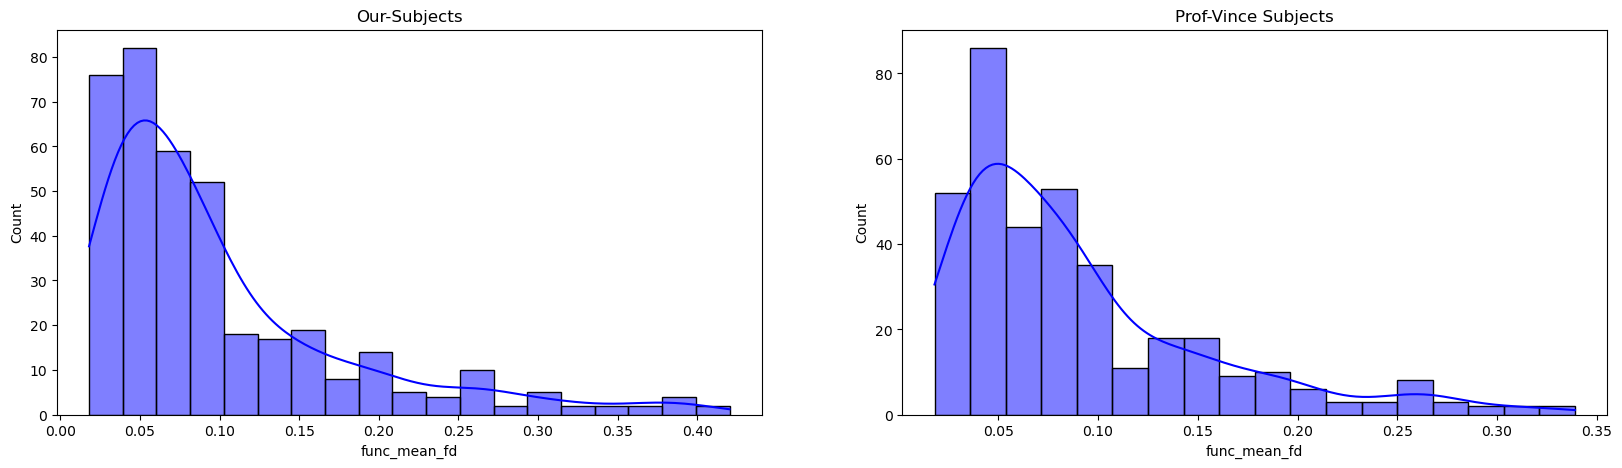

In [10]:
fig = plt.figure(figsize=(20, 5))
plt.subplot(1,2,1)
sns.histplot(x = 'func_mean_fd', data = df_final, kde = True, color = 'blue', label = 'Our Subjects')
plt.title('Our-Subjects')
plt.subplot(1,2,2)
sns.histplot(x = 'func_mean_fd', data = gift, kde = True, color = 'blue', label = 'Prof-Vince-Subjects')
plt.title('Prof-Vince Subjects')
plt.show()

In [11]:
df_final['ADOS_TOTAL'].isnull().sum()

230

In [13]:
df_final[df_final['DX_GROUP'] == 1]['ADOS_TOTAL'].isnull().sum()

59

In [17]:
df_final['ADOS_TOTAL'].value_counts()

 10.0      17
 12.0      15
 14.0      11
 13.0      11
 7.0       10
 11.0      10
 8.0        9
 9.0        7
 0.0        7
 17.0       7
 18.0       7
 1.0        6
 16.0       6
 15.0       6
 19.0       5
 2.0        5
-9999.0     4
 5.0        3
 6.0        2
 4.0        2
 3.0        1
 21.0       1
 22.0       1
Name: ADOS_TOTAL, dtype: int64

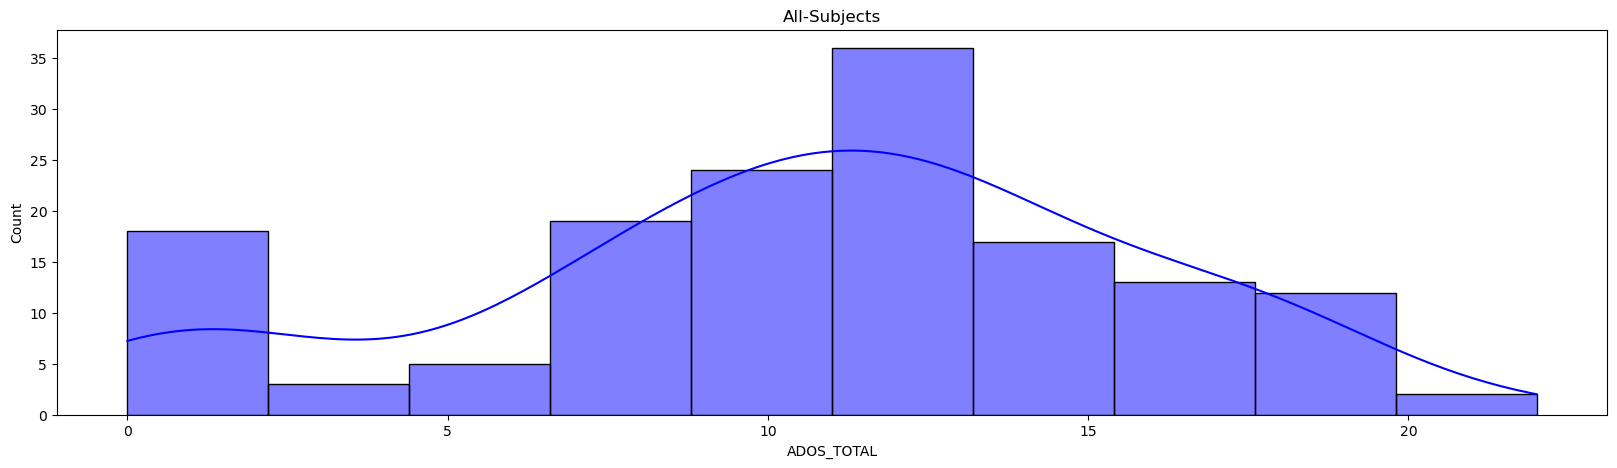

In [19]:
fig = plt.figure(figsize=(20, 5))
sns.histplot(x = 'ADOS_TOTAL', data = df_final[df_final['ADOS_TOTAL'] != -9999.0], kde = True, color = 'blue', label = 'Our Subjects')
plt.title('All-Subjects')
plt.show()

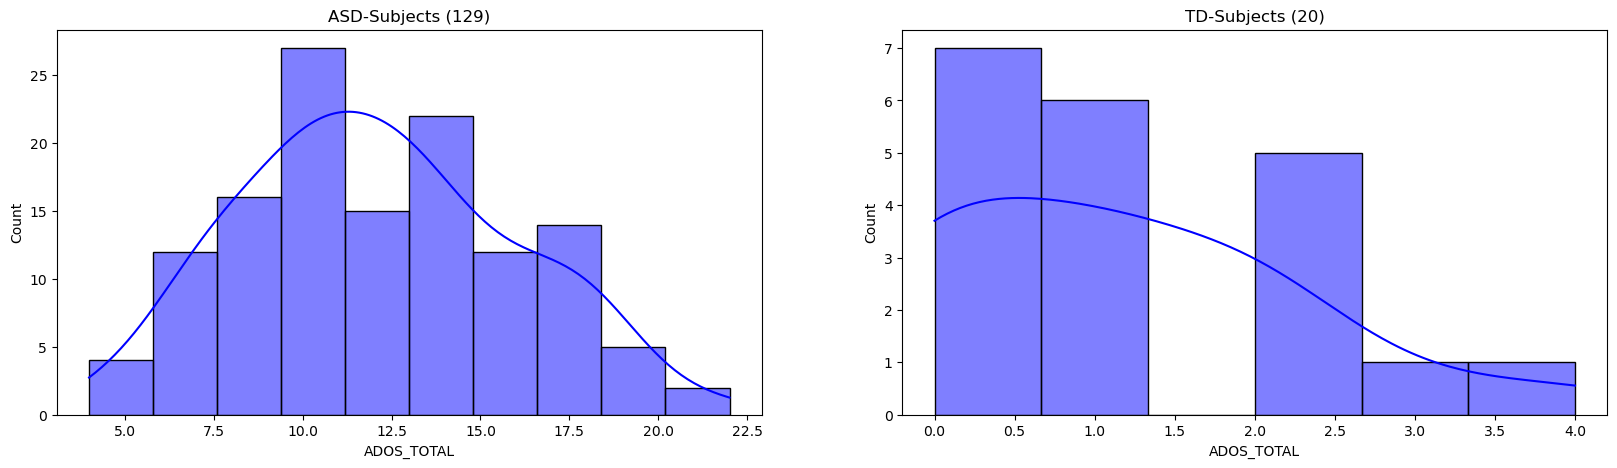

In [28]:
fig = plt.figure(figsize=(20, 5))
plt.subplot(1,2,1)
sns.histplot(x = 'ADOS_TOTAL', data = df_final[(df_final['ADOS_TOTAL'] != -9999.0) & (df_final['DX_GROUP'] == 1)], kde = True, color = 'blue', label = 'Our Subjects')
plt.title(f'ASD-Subjects ({len(df_final[(df_final["ADOS_TOTAL"].notnull()) & (df_final["ADOS_TOTAL"] != -9999.0) & (df_final["DX_GROUP"] == 1)])})')
plt.subplot(1,2,2)
sns.histplot(x = 'ADOS_TOTAL', data = df_final[(df_final['ADOS_TOTAL'] != -9999.0) & (df_final['DX_GROUP'] == 0)], kde = True, color = 'blue', label = 'Our Subjects')
plt.title(f'TD-Subjects ({len(df_final[(df_final["ADOS_TOTAL"].notnull()) & (df_final["ADOS_TOTAL"] != -9999.0) & (df_final["DX_GROUP"] == 0)])})')
plt.show()

# Analysis of Final subjects selected

In [3]:
df_final = pd.read_csv('./Phenotypes/Final_Subjects.csv', index_col='SUB_ID')
print('Shape of final dataset : ', df_final.shape)
df_final.head()

Shape of final dataset :  (383, 104)


,subject,SITE_ID,FILE_ID,DX_GROUP,DSM_IV_TR,AGE_AT_SCAN,SEX,HANDEDNESS_CATEGORY,HANDEDNESS_SCORES,FIQ,...,qc_anat_notes_rater_2,qc_func_rater_2,qc_func_notes_rater_2,qc_anat_rater_3,qc_anat_notes_rater_3,qc_func_rater_3,qc_func_notes_rater_3,SUB_IN_SMP,TR,Timeframes
SUB_ID,,,,,,,,,,,,,,,,,,,,,
50182,50182,SDSU,SDSU_0050182,1,2,16.61,0,R,NaN,115.0,...,NaN,OK,NaN,OK,NaN,OK,NaN,1,2000.0,176.0
50183,50183,SDSU,SDSU_0050183,1,1,14.14,0,R,NaN,139.0,...,NaN,OK,NaN,OK,NaN,OK,NaN,1,2000.0,176.0
50184,50184,SDSU,SDSU_0050184,1,2,17.15,0,R,NaN,141.0,...,NaN,OK,NaN,OK,NaN,OK,NaN,0,2000.0,176.0
50186,50186,SDSU,SDSU_0050186,1,2,12.13,0,R,NaN,112.0,...,NaN,OK,NaN,OK,NaN,OK,NaN,1,2000.0,176.0
50187,50187,SDSU,SDSU_0050187,1,2,16.48,0,R,NaN,113.0,...,NaN,OK,NaN,OK,NaN,OK,NaN,1,2000.0,176.0


In [4]:
df_final.isnull().sum()

subject                    0
SITE_ID                    0
FILE_ID                    0
DX_GROUP                   0
DSM_IV_TR                  0
                        ... 
qc_func_rater_3            0
qc_func_notes_rater_3    381
SUB_IN_SMP                 0
TR                         0
Timeframes                 0
Length: 104, dtype: int64

### AGE

In [11]:
df_final['AGE_AT_SCAN'].isnull().sum()

0

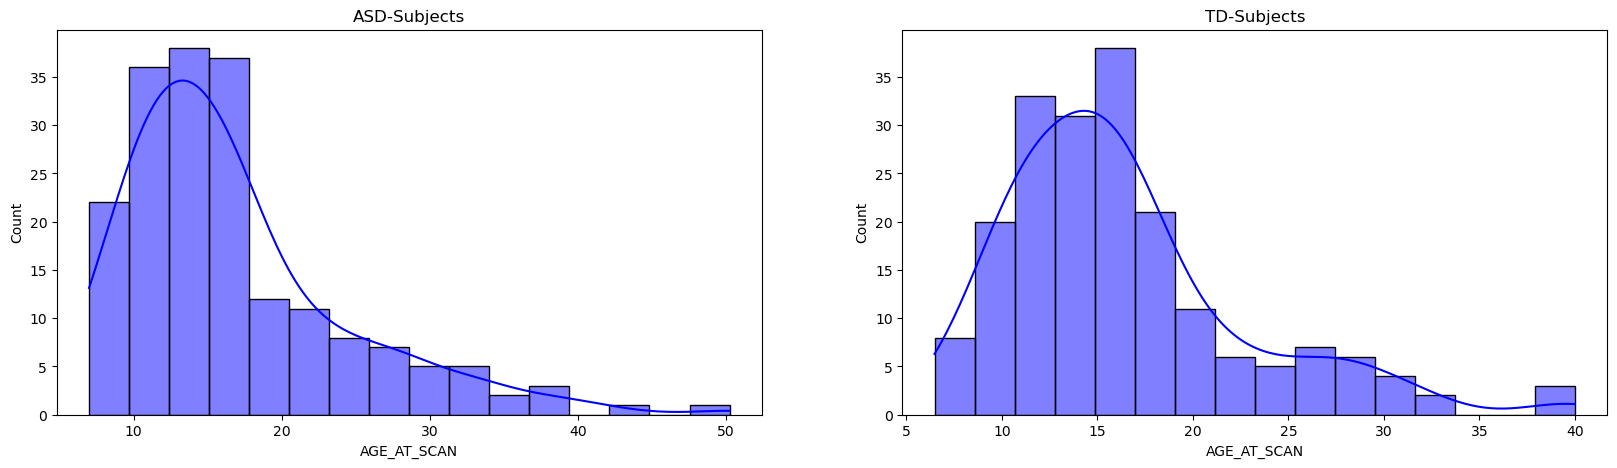

In [6]:
fig = plt.figure(figsize=(20, 5))
plt.subplot(1,2,1)
sns.histplot(x = 'AGE_AT_SCAN', data = df_final[df_final['DX_GROUP'] == 1], kde = True, color = 'blue', label = 'ASD Subjects')
plt.title(f'ASD-Subjects')
plt.subplot(1,2,2)
sns.histplot(x = 'AGE_AT_SCAN', data = df_final[df_final['DX_GROUP'] == 0], kde = True, color = 'blue', label = 'TD Subjects')
plt.title(f'TD-Subjects')
plt.show()

In [15]:
asd = df_final[df_final['DX_GROUP'] == 1]['AGE_AT_SCAN'].values
td = df_final[df_final['DX_GROUP'] == 0]['AGE_AT_SCAN'].values
t_age, p_age = scipy.stats.ttest_ind(asd, td)
print('AGE t-statistic : ', t_age)
print('AGE p-value : ', p_age)

AGE t-statistic :  0.6156019957610444
AGE p-value :  0.5385247861623661


## FIQ, PIQ, VIQ

In [12]:
df_final['FIQ'].isnull().sum()

0

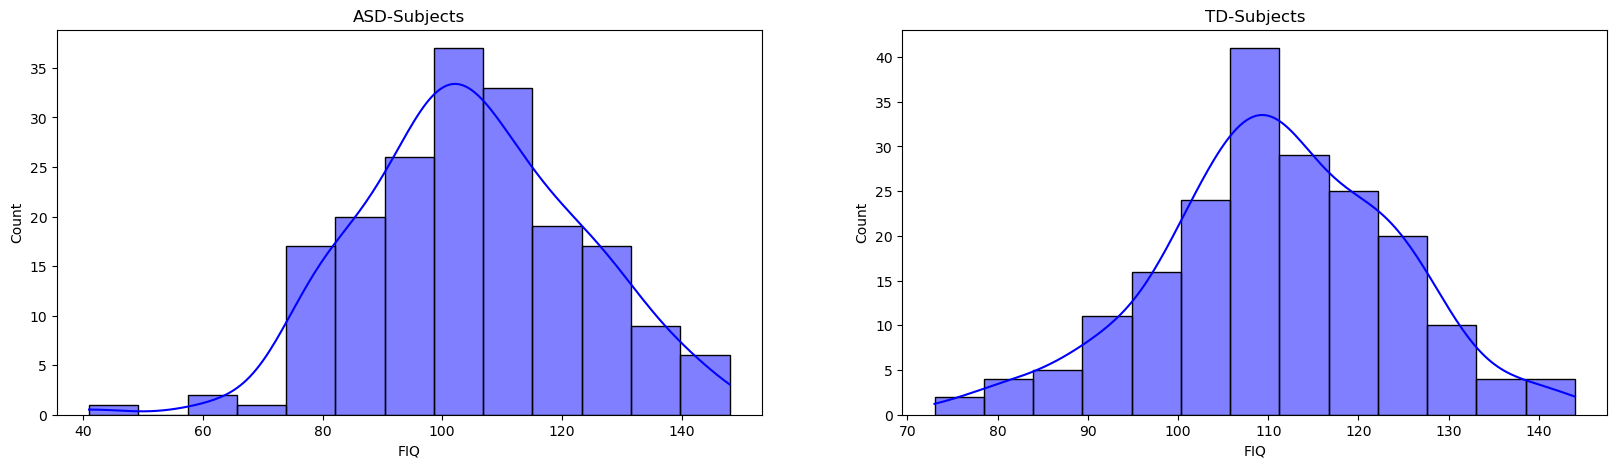

In [13]:
fig = plt.figure(figsize=(20, 5))
plt.subplot(1,2,1)
sns.histplot(x = 'FIQ', data = df_final[df_final['DX_GROUP'] == 1], kde = True, color = 'blue', label = 'ASD Subjects')
plt.title(f'ASD-Subjects')
plt.subplot(1,2,2)
sns.histplot(x = 'FIQ', data = df_final[df_final['DX_GROUP'] == 0], kde = True, color = 'blue', label = 'TD Subjects')
plt.title(f'TD-Subjects')
plt.show()

In [16]:
asd = df_final[df_final['DX_GROUP'] == 1]['FIQ'].values
td = df_final[df_final['DX_GROUP'] == 0]['FIQ'].values
t, p = scipy.stats.ttest_ind(asd, td)
print('AGE t-statistic : ', t)
print('AGE p-value : ', p)

AGE t-statistic :  -3.7929401103740394
AGE p-value :  0.00017307035440407376


In [17]:
df_final['PIQ'].isnull().sum()

0

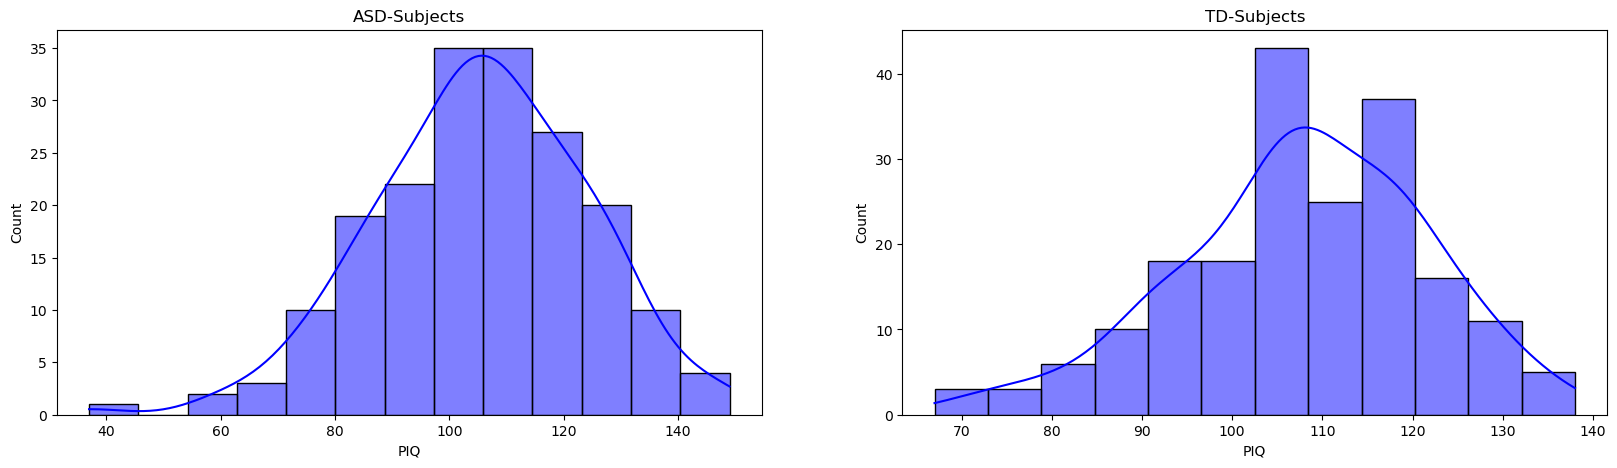

In [19]:
fig = plt.figure(figsize=(20, 5))
plt.subplot(1,2,1)
sns.histplot(x = 'PIQ', data = df_final[df_final['DX_GROUP'] == 1], kde = True, color = 'blue', label = 'ASD Subjects')
plt.title(f'ASD-Subjects')
plt.subplot(1,2,2)
sns.histplot(x = 'PIQ', data = df_final[df_final['DX_GROUP'] == 0], kde = True, color = 'blue', label = 'TD Subjects')
plt.title(f'TD-Subjects')
plt.show()

In [20]:
asd = df_final[df_final['DX_GROUP'] == 1]['PIQ'].values
td = df_final[df_final['DX_GROUP'] == 0]['PIQ'].values
t, p = scipy.stats.ttest_ind(asd, td)
print('AGE t-statistic : ', t)
print('AGE p-value : ', p)

AGE t-statistic :  -1.483393979445617
AGE p-value :  0.13879649550070394


In [18]:
df_final['VIQ'].isnull().sum()

0

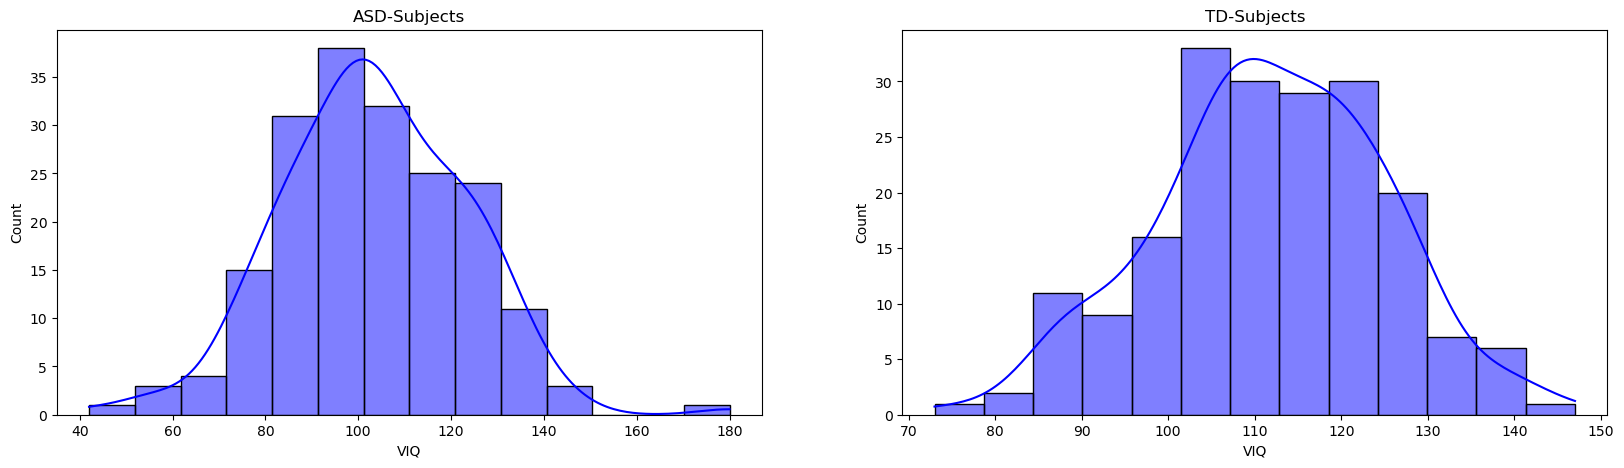

In [21]:
fig = plt.figure(figsize=(20, 5))
plt.subplot(1,2,1)
sns.histplot(x = 'VIQ', data = df_final[df_final['DX_GROUP'] == 1], kde = True, color = 'blue', label = 'ASD Subjects')
plt.title(f'ASD-Subjects')
plt.subplot(1,2,2)
sns.histplot(x = 'VIQ', data = df_final[df_final['DX_GROUP'] == 0], kde = True, color = 'blue', label = 'TD Subjects')
plt.title(f'TD-Subjects')
plt.show()

In [22]:
asd = df_final[df_final['DX_GROUP'] == 1]['FIQ'].values
td = df_final[df_final['DX_GROUP'] == 0]['FIQ'].values
t, p = scipy.stats.ttest_ind(asd, td)
print('AGE t-statistic : ', t)
print('AGE p-value : ', p)

AGE t-statistic :  -4.918345635837785
AGE p-value :  1.3004004538553236e-06
